<a href="https://colab.research.google.com/github/MarvNC/cs523/blob/master/s25_chapter5_handout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preface

Update from the video: I introduce sklearn's built-in scalers, `MinMaxScaler` and `StandardScaler`, mostly as motivation for why we will want to write our own custom scaler.

<center>
<h1>Chapter Five</h1>
</center>

<hr>

## LEARNING OBJECTIVES:
- Look at next wrangling step up, scaling. Introduce several alternatives.
- Capture final choice, RobustScaler, in a custom Transformer.
- Place it correctly in Pipeline.

# I. Scaling

In this chapter I would like to look at the next step in our pipeline, scaling. The general idea is to try to "smooth" out our data so it is in the same "ballpark". As one example, the Fare column ranges from 0 to 500+. The Gender column ranges from 0 to 1. Quite a disparity! We will look at methods to deal with this.


## Set-up

First bring in your library.

In [ ]:
github_name = 'MarvNC'
repo_name = 'cs523'
source_file = 'library.py'
url = f'https://raw.githubusercontent.com/{github_name}/{repo_name}/main/{source_file}'
# !rm $source_file
# !wget $url
# %run -i $source_file
from library import *

'https://raw.githubusercontent.com/MarvNC/cs523/main/library.py'

## Make sure transformers from chapter 4 are in your library

In [2]:
customer_transformer  #6 steps

Pipeline(steps=[('drop', CustomDropColumnsTransformer(column_list=['ID'])),
                ('gender',
                 CustomMappingTransformer(mapping_column='Gender',
                                          mapping_dict={'Female': 1,
                                                        'Male': 0})),
                ('experience_level',
                 CustomMappingTransformer(mapping_column='Experience Level',
                                          mapping_dict={'high': 2, 'low': 0,
                                                        'medium': 1})),
                ('os', CustomOHETransformer(target_column='OS')),
                ('isp', CustomOHETransformer(target_column='ISP')),
                ('time spent',
                 CustomTukeyTransformer(fence='inner',
                                        target_column='Time Spent'))],
         verbose=True)

In [3]:
titanic_transformer  #4 steps

Pipeline(steps=[('gender',
                 CustomMappingTransformer(mapping_column='Gender',
                                          mapping_dict={'Female': 1,
                                                        'Male': 0})),
                ('class',
                 CustomMappingTransformer(mapping_column='Class',
                                          mapping_dict={'C1': 3, 'C2': 2,
                                                        'C3': 1, 'Crew': 0})),
                ('joined', CustomOHETransformer(target_column='Joined')),
                ('fare', CustomTukeyTransformer(target_column='Fare'))],
         verbose=True)

In [108]:
url = 'https://raw.githubusercontent.com/fickas/asynch_models/refs/heads/main/datasets/titanic_trimmed.csv'
titanic_table = pd.read_csv(url)  #using our new package to read in an entire dataset - the coolest

In [109]:
titanic_table.head()  #print first 5 rows of the table

,Age,Gender,Class,Joined,Married,Fare,Survived
0,41.0,Male,C3,Southampton,0.0,7.0,0
1,21.0,Male,Crew,Southampton,0.0,0.0,0
2,13.0,Male,C3,Southampton,NaN,20.0,0
3,16.0,Male,C3,Southampton,0.0,NaN,0
4,NaN,Male,C2,Cherbourg,0.0,24.0,0


In [110]:
titanic_features = titanic_table.drop(columns='Survived')

## Wrangle using your pipeline

I added a Tukey check on `Fare`.  I am using the outer fence, meaning I am only interested in "probables".

If you are still working on the `TukeyTransformer` from last chapter, you can leave it off for now.

In [111]:
transformed_df: pd.DataFrame = titanic_transformer.fit_transform(titanic_features)

[Pipeline] ............ (step 1 of 4) Processing gender, total=   0.0s


[Pipeline] ............. (step 2 of 4) Processing class, total=   0.0s
[Pipeline] ............ (step 3 of 4) Processing joined, total=   0.0s
[Pipeline] .............. (step 4 of 4) Processing fare, total=   0.0s


In [112]:
transformed_df.head()

,Age,Gender,Class,Married,Fare,Joined_Belfast,Joined_Cherbourg,Joined_Queenstown,Joined_Southampton
0,41.0,0,1.0,0.0,7.0,0,0,0,1
1,21.0,0,0.0,0.0,0.0,0,0,0,1
2,13.0,0,1.0,NaN,20.0,0,0,0,1
3,16.0,0,1.0,0.0,NaN,0,0,0,1
4,NaN,0,2.0,0.0,24.0,0,1,0,0


In [9]:
transformed_df.dtypes  #all numeric

Age                   float64
Gender                  int64
Class                 float64
Married               float64
Fare                  float64
Joined_Belfast          int64
Joined_Cherbourg        int64
Joined_Queenstown       int64
Joined_Southampton      int64
dtype: object

In [10]:
#making sure you have run Fare through Tukey
transformed_df['Fare'].min(), transformed_df['Fare'].max()  #(0.0, 101.0)

(0.0, 101.0)

# II. Transforming columns as apples to apples
<img src='https://www.dropbox.com/s/9fcc1crlxp19ijt/major_section.png?raw=1' width='300'>

Looking ahead, I know some of the machine learning algorithms we will look at are sensitive to large range discrepencies between columns. As an example, look at the first 2 rows. If we calculate the difference between these 2 rows, we will get a difference of 20 for `Age` but a difference of 1 for `Class`. If we use something like Euclidean distance, treating each row as a point, we will use this formula to get the difference between the rows:

<img src='https://www.dropbox.com/s/y2pucqx4e8uokj6/Screen%20Shot%202021-09-01%20at%201.09.02%20PM.png?raw=1'>

I hope you see that the `Age` difference (now squared to get to 400!) will swamp the `Class` difference (1 squared). We might as well drop all the columns with small values and just keep `Age` and `Fare`.

But I want the other columns! They may carry valuable information. The solution is to get their ranges all in same ballpark.

## Build a test table

I'll use this for demo purposes. There are only 2 columns we need to worry about, `Age` and `Fare`. The remaining columns are binary or close to binary. So `Age` and `Fare` are the problems.

In [15]:
demo_df = transformed_df[['Age', 'Fare']]
demo_df.describe(include='all').T  # different than video

,count,mean,std,min,25%,50%,75%,max
Age,1304.0,31.574387,14.346945,1.0,22.0,30.5,41.0,74.0
Fare,1311.0,25.253074,28.750343,0.0,7.0,13.0,30.5,101.0


<pre>

count	mean	std	min	25%	50%	75%	max
Age	1304.0	31.574387	14.346945	1.0	22.0	30.5	41.0	74.0
Fare	1311.0	25.253074	28.750343	0.0	7.0	13.0	30.5	101.0
</pre>

## Reminder of what we have before scaling

<Axes: ylabel='Frequency'>

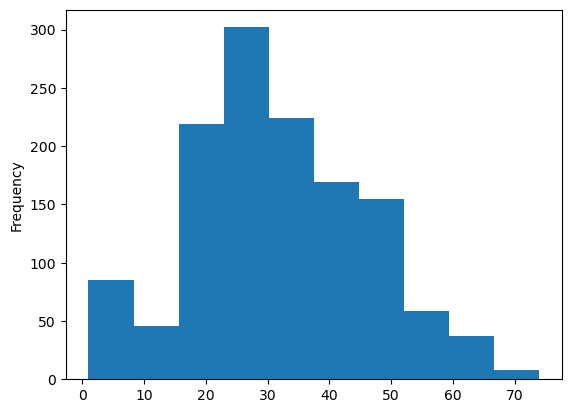

In [16]:
transformed_df['Age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

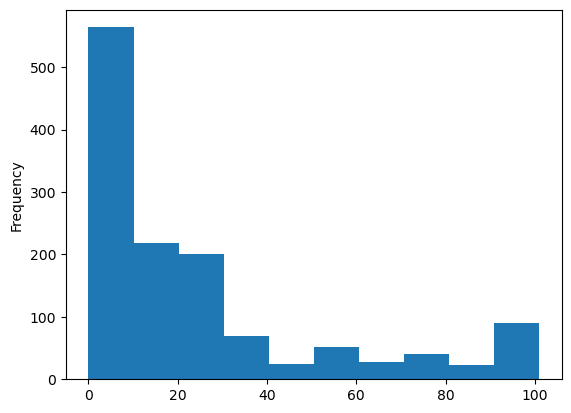

In [17]:
transformed_df['Fare'].plot(kind='hist')

# III. Min-Max scaling

A very standard approach is to place each column in the range between 0 and 1 (inclusive). The formula for this is:

<img src='https://www.dropbox.com/s/j4j2jhkmuweej1s/Screen%20Shot%202021-09-01%20at%201.16.27%20PM.png?raw=1'>

A little confusing. Read it as (a) take the min of the column, (b) take the max of the column, (c) take each value and scale as shown to get new value. This will give you a range of 0 to 1 for entire column.

<img src='https://www.dropbox.com/s/8x575mvbi1xumje/cash_line.png?raw=1' height=3 width=500><br>
<img src='https://www.gannett-cdn.com/-mm-/56cbeec8287997813f287995de67747ba5e101d5/c=9-0-1280-718/local/-/media/2018/02/15/Phoenix/Phoenix/636542954131413889-image.jpg'
height=50 align=center>

Go ahead and test the formula above for the `Age` column. Apply the formula above to the column. See what the resulting min and max are. Should be 0 and 1.

You should be able to use pandas methods to do what you want.

BTW: I want the scaled Age in a new dataframe, `demo2`.




In [18]:
demo2 = demo_df.copy()
#your code below. You will need min and max of Age. Then use formula to scale the Age column. Note I needed no loops or comprehensions by using built-in pandas operators.

age_min = demo_df['Age'].min()
age_max = demo_df['Age'].max()
demo2['Age'] = (demo_df['Age'] - age_min) / (age_max - age_min)


In [19]:
(demo2['Age'].min(), demo2['Age'].max())  #(0.0, 1.0)

(0.0, 1.0)

<Axes: ylabel='Frequency'>

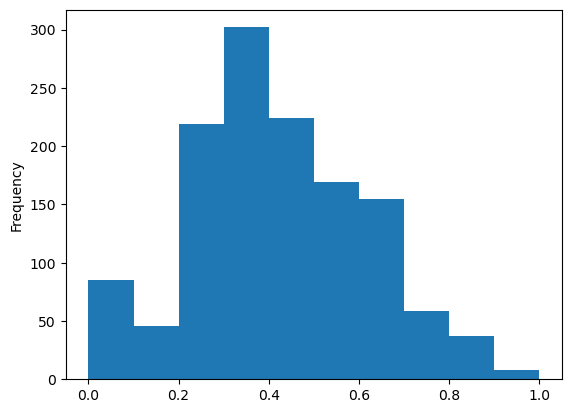

In [20]:
demo2['Age'].plot(kind='hist')  #shape has not changed, just scale of x-axis

Now do same for Fare column. Use demo2 as starting point.

In [21]:
#your code below

fare_min = demo_df['Fare'].min()
fare_max = demo_df['Fare'].max()
demo2['Fare'] = (demo_df['Fare'] - fare_min) / (fare_max - fare_min)


In [22]:
(demo2['Fare'].min(), demo2['Fare'].max())  #(0.0, 1.0)

(0.0, 1.0)

<Axes: ylabel='Frequency'>

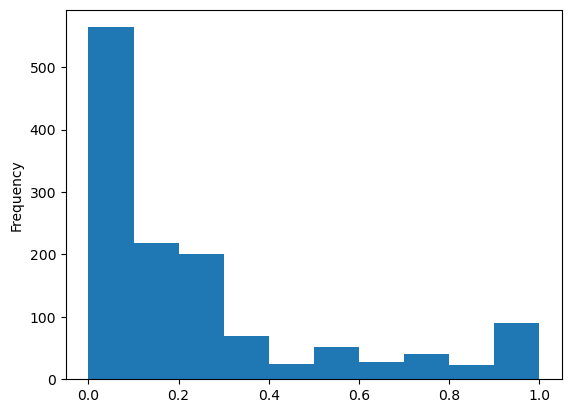

In [23]:
demo2['Fare'].plot(kind='hist')  #ditto - no change to shape just to scale

### You can see distribution has not changed

`Age` still semi-normal.

`Fare` still right-skewed.

### sklearn has a transformer

<pre>
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit_transform(data)
</pre>
I hope you can see that this scaler  will give uniform ranges (between 0 and 1) to every column/feature. So apples to apples.

Also note that this transformer is set up to work on the entire table, feature by feature. So you don't name a column/feature as target. The target is all the columns. But that is part of the problem. I may want to apply different scalers to different columns depending on their distributions. More later.

In [24]:
from sklearn.preprocessing import MinMaxScaler
scaler =  MinMaxScaler()
numpy_result = scaler.fit_transform(demo_df)  #does not return a dataframe!
new_df = pd.DataFrame(numpy_result, columns=['Age', 'Fare'])  #turn it back into a dataframe
new_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,1304.0,0.418827,0.196533,0.0,0.287671,0.404110,0.547945,1.0
Fare,1311.0,0.250030,0.284657,0.0,0.069307,0.128713,0.301980,1.0


<Axes: ylabel='Frequency'>

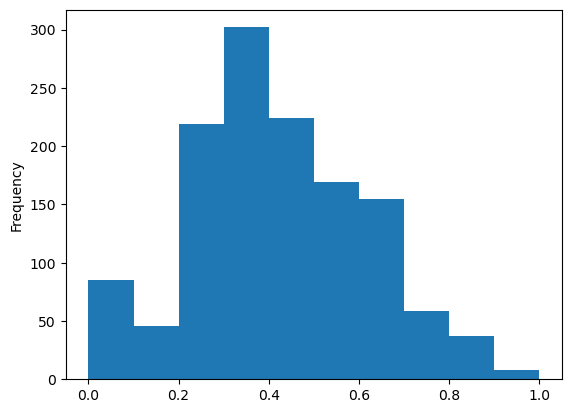

In [25]:
new_df['Age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

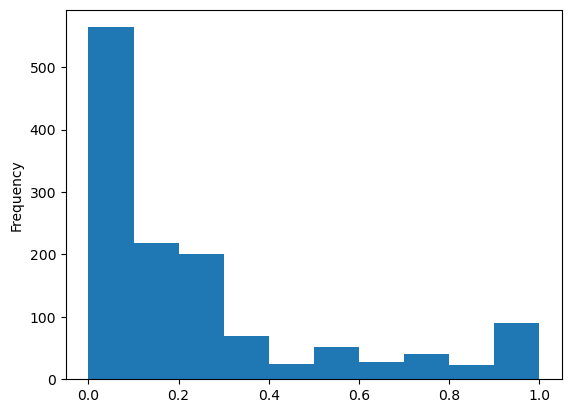

In [26]:
new_df['Fare'].plot(kind='hist')

# VI. Standardization (Z-score Normalization) Apples to Pears

This is a slightly different approach that is less senstive to outliers.

<img src='https://www.dropbox.com/s/bg7r231qrhfiiir/Screen%20Shot%202021-09-01%20at%201.56.09%20PM.png?raw=1'>

We subtract the mean of the column and divide by the standard deviation (sigma) of the column.  In essence, use the old column to calculate how many sigmas a value is from the mean.

<img src='https://www.dropbox.com/s/8x575mvbi1xumje/cash_line.png?raw=1' height=3 width=500><br>
<img src='https://www.gannett-cdn.com/-mm-/56cbeec8287997813f287995de67747ba5e101d5/c=9-0-1280-718/local/-/media/2018/02/15/Phoenix/Phoenix/636542954131413889-image.jpg'
height=50 align=center>


 Apply the formula above to the `Fare` column. See what the resulting min and max are. Are they 0 and 1?

Remember that pandas has methods for mean and standard deviation.




In [27]:
demo2 = demo_df.copy()
#your code below

fare_stddev = demo_df['Fare'].std()
fare_mean = demo_df['Fare'].mean()
demo2['Fare'] = (demo_df['Fare'] - fare_mean) / fare_stddev

In [28]:
(demo2['Fare'].min(), demo2['Fare'].max())  #(-0.8783573098490415, 2.6346442491796966)

(-0.8783573098490415, 2.6346442491796966)

### Still mostly apples to apples

Ranges from `-.87` to `2.63`. Seems ok.

### pandas handles NaN values gracefully

There are NaN values in both Fare and Age. Let's see what happens if we decide to do our own thing without pandas methods.

In [30]:
from statistics import mean, stdev
fares = demo_df['Fare'].to_list()
me = mean(fares)
me

nan

The takehome message is to use pandas methods whenever you can - they know about NaN and deal with them gracefully.

### There is a transformer for Z-score normalization

<pre>
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(data)
</pre>

Note that this will not give you the same range across columns.

In [31]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
new_df = pd.DataFrame(scaler.fit_transform(demo_df), columns=['Age', 'Fare'])
new_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,1304.0,1.008055e-16,1.000384,-2.131891,-0.667603,-0.074915,0.657229,2.958253
Fare,1311.0,1.083971e-16,1.000382,-0.878692,-0.635124,-0.426351,0.182569,2.635650


### Distribution roughly the same

<Axes: ylabel='Frequency'>

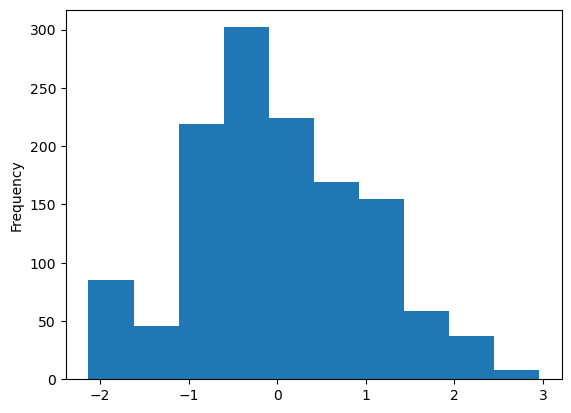

In [32]:
new_df['Age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

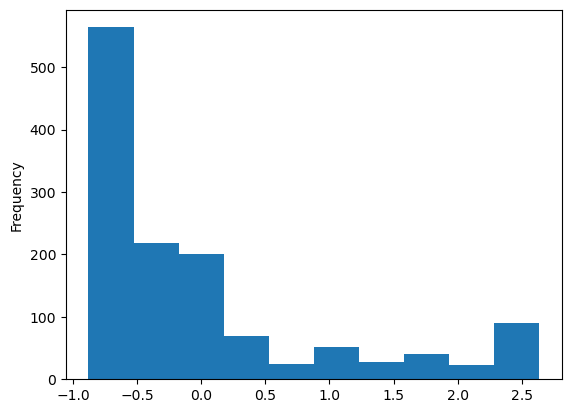

In [33]:
new_df['Fare'].plot(kind='hist')

But again, it only operates on the entire table and that may not be what we want.

# V. Robust Scaler

As we saw in chapter 4, any method that uses the mean and standard deviation has issues with outlier values. Outliers can skew a probability distribution and make data scaling using standardization difficult as the calculated mean and standard deviation will be skewed by the presence of the outliers.

We also saw in chapter 4 that switching from mean and sigma to the use of quartiles could help with outliers. There is a scaler that uses the idea: the Robust Scaler.

Here is the formula:

`value_new = (value – median) / iqr #iqr = q3-q1`

The resulting values have (approximately) a zero mean and median and a standard deviation of 1. If you want a more detailed discussion of this, see [Robust Scaler tutorial](https://proclusacademy.com/blog/robust-scaler-outliers/).



And as usual, sklearn has this transformer defined.

<pre>
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit_transform(data)
</pre>

In [34]:
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
new_df = pd.DataFrame(scaler.fit_transform(demo_df), columns=['Age', 'Fare'])
new_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,1304.0,0.056547,0.755102,-1.552632,-0.447368,0.0,0.552632,2.289474
Fare,1311.0,0.521407,1.223419,-0.553191,-0.255319,0.0,0.744681,3.744681


## Still looking pretty good

Both columns are in the apples to apples range. Note that if we had not applied Tukey to Fare, this would not be the case. When I tried RobustScaler without Tukey, I go a max of 35, which is too large.

<Axes: ylabel='Frequency'>

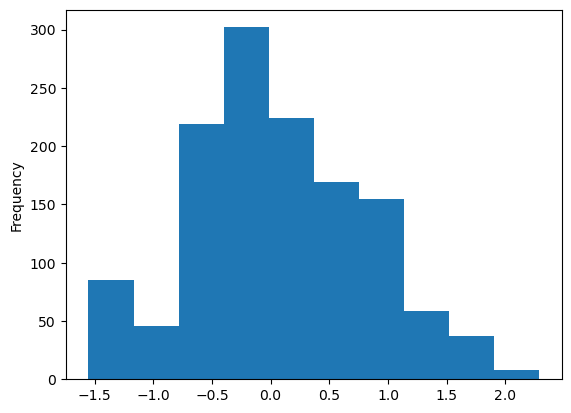

In [35]:
new_df['Age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

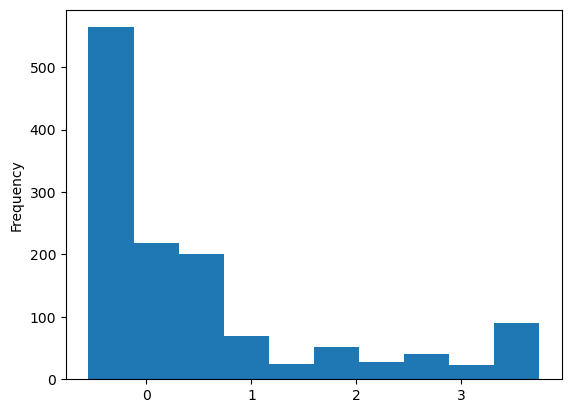

In [36]:
new_df['Fare'].plot(kind='hist')

# VI. Box Cox normalizer

Up until know, we have been looking at transforms that use linear methods. The next set we look at will attempt to normalize the dataset by unskewing it if necessary. This involves non-linear transformations that can be a bit murky in terms of interpretability. The first is a method called Box Cox. It takes a column of values in and does an exhaustive search on a parameter called lambda using this equation:

<img src='https://www.dropbox.com/s/esqhkw8cgyh4nya/Screen%20Shot%202022-09-22%20at%2010.09.45%20AM.png?raw=1' height=100>

or simplified

<img src='https://www.dropbox.com/s/xj6wxava4ofhgf4/Screen%20Shot%202022-09-22%20at%2010.10.24%20AM.png?raw=1' height=75>

The old column values are `yi`. The new values are `yi(λ)`. A search is done over lambda between -5 to +5. The lambda value that gives the closest to a normal distribution of `yi(λ)` is chosen. See [Fit goodness paper](https://arxiv.org/pdf/1401.3812.pdf).

Note the limit of Yi to the lambda minus 1 over lambda, as lambda approaches 0, is log yi. That covers the lambda=0 case.

**The values `yi` must be strictly positive.**

<img src='https://capture.dropbox.com/NqYhzu3P2muKakkM?raw=1'>

In [37]:
demo_df['Fare'] += .00001  #to make all values positive
demo_df['Age'] += .00001  #to make all values positive

/tmp/ipykernel_49993/4188931768.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_df['Fare'] += .00001  #to make all values positive
/tmp/ipykernel_49993/4188931768.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  demo_df['Age'] += .00001  #to make all values positive


In [40]:
demo_df['Fare'].min()  #was 0 now slightly positive

1e-05

### Using another built-in sklearn transformer

Which again operates on all columns: you cannot select column to work on.

In [41]:
from sklearn.preprocessing import PowerTransformer
scaler = PowerTransformer(method='box-cox')
new_df = pd.DataFrame(scaler.fit_transform(demo_df), columns=['Age', 'Fare'])
new_df.describe(include='all').T # different than video


,count,mean,std,min,25%,50%,75%,max
Age,1304.0,1.743663e-16,1.000384,-2.367236,-0.632676,-0.034756,0.670255,2.736505
Fare,1311.0,-1.083971e-16,1.000382,-1.876567,-0.176358,0.111551,0.586490,1.444463


### Mostly apples to apples

`Age` ranges from -2.75 to 3.23. `Fare` from -1.18 to 1.16. I'd say this is acceptable.

<Axes: ylabel='Frequency'>

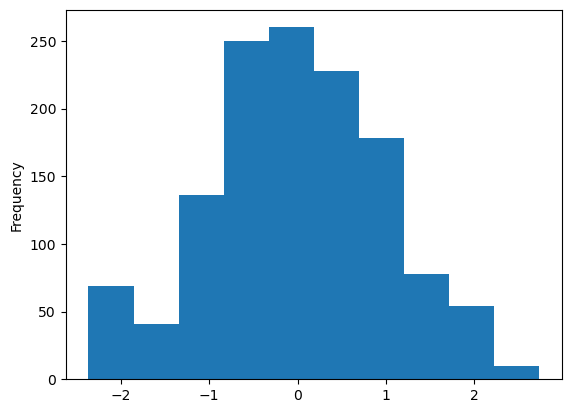

In [42]:
new_df['Age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

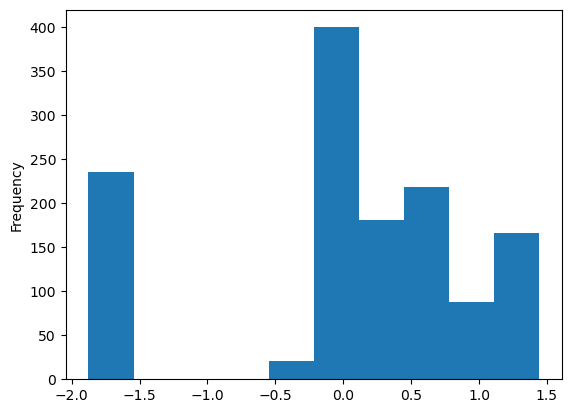

In [43]:
new_df['Fare'].plot(kind='hist')

In [44]:
new_df['Fare'].skew()  #-0.7805798491257958

-0.7805798311296728

# VII. Yeo Johnson

A modifiction of Box Cox that removes the restriction of positive numbers is the Yeo-Johnson transform:

<img src='https://www.dropbox.com/s/jgx6tc04jf3wvd8/Screen%20Shot%202021-09-02%20at%2010.43.07%20AM.png?raw=1' height=100>

Like Box-Cox, a search is done over lambda to find the value that most closely produces a normal distribution.

In [45]:
scaler = PowerTransformer(method='yeo-johnson')
new_df = pd.DataFrame(scaler.fit_transform(demo_df), columns=['Age', 'Fare'])
new_df.describe(include='all').T  #different than video

,count,mean,std,min,25%,50%,75%,max
Age,1304.0,-1.280503e-16,1.000384,-2.337992,-0.636649,-0.037996,0.669986,2.752743
Fare,1311.0,-9.755736e-17,1.000382,-1.609583,-0.460467,-0.061823,0.599782,1.767552


### Again, mostly apples to apples

<Axes: ylabel='Frequency'>

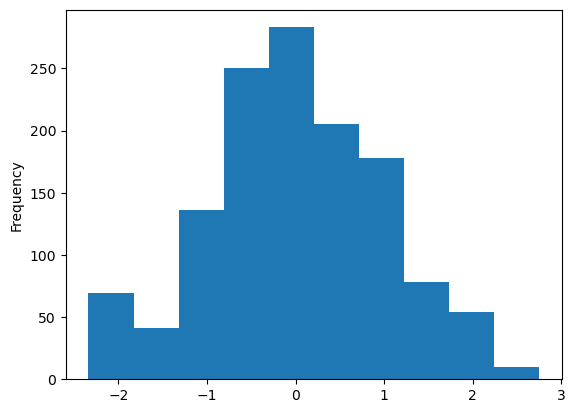

In [46]:
new_df['Age'].plot(kind='hist')

<Axes: ylabel='Frequency'>

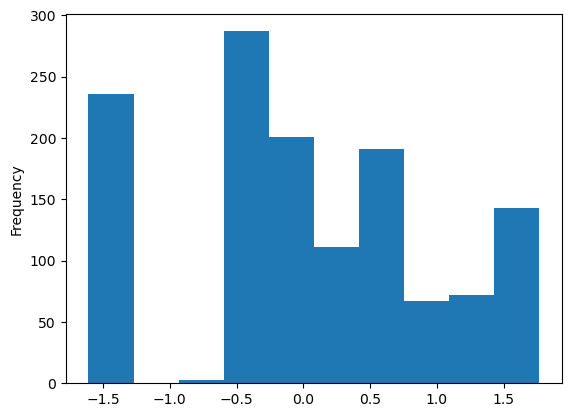

In [47]:
new_df['Fare'].plot(kind='hist') # different than video

In [48]:
new_df['Fare'].skew()  #-0.07294022105966637

-0.07294022105966637

# X. So which to choose?

I see 3 questions we need to ask:

1. Do the machine learning algorithms we will use care about skewness? Do they prefer a normal distribution? Related, are they sensitive to outliers?

2. Does apples-to-apples matter? Should all columns be in roughly the same range?

3. Do we care about interpretability, i.e., explaining what we did to a human in an understandable way?

* The answer to 1 is "some do care". We will end up looking at more than one algorithm and some may care and some not. Note that we have done outlier clipping at least on the `Fare` column before we get to here. That can remove outliers but can still leave a skewed set of data.

* The answer to 2 is "most algorithms care" and in at least one case it is critical.

* The answer to 3 is yes, we will care about explaintability. We will be presenting results to an end user through a web site. I want to pay attention to being able to explain the analysis we do.

My choice: Robust Scaler. It gives us  similar ranges and an extra benefit is that it is explainable.



# Challenge 1
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

<img src='https://www.dropbox.com/s/esqhkw8cgyh4nya/Screen%20Shot%202022-09-22%20at%2010.09.45%20AM.png?raw=1' height=100>

Try your hand at the Box-Cox scaler. I know we have seen it is built-in to the PowerTransformer. But I would like you to see if you can code it yourself. Here is what I would like you to do:

1. Use `demo_df['Fare']` after you make it positive - no 0s allowed. We did that by adding a small positive constant. I'd like you to use the full column, not just the last 100.

2. There may be a way to do this all within pandas, but I decided to pull the column out into a Python list and work with that. So do that. Rest of steps assume you are working with a Python list - no pandas involved.

3. Run through lambda values between integers -5 and +5. Warning: `lambda` is a reserved word so don't name your variables with it.

4. Compute the box-cox formula on the `Fare` list to give you a new set of scaled values. **Big warning**: you will have to skip over `NaN` values in the list. So the scaled list you come up with will be smaller than full column.

4. I will actually give you a skew function to use as a "goodness" measure. Record the skew along with lambda value.

5. Choose the lambda value that gets you closest to 0 skew. Use the Python `sorted` method to do this.

6. Use that lambda value to compute final scaled new values. Warning: it will not match up with sklearn transformer but that's ok. You should end up with a new list that is scaled.

I'll give you my results to match against.



In [ ]:
from typing import List, Union

def compute_box_cox(data: List[float], lambda_val: Union[int, float]) -> List[float]:
    """
    Applies the Box-Cox transformation to a list of positive numbers.

    Parameters
    ----------
    data : List[float]
        A list of strictly positive floating-point numbers.
    lambda_val : Union[int, float]
        The lambda parameter for the Box-Cox transformation.

    Returns
    -------
    List[float]
        The list containing the transformed values.
    """
    if lambda_val == 0:
        return [math.log(x) for x in data]
    else:
        return [((x ** lambda_val) - 1) / lambda_val for x in data]

In [70]:
#I'll give you the imports I used so you can match against my results
import math

from scipy.stats import skew

#code to compute skew values (11 of them: -5...0...5)

boxcoxdf = transformed_df['Fare'].copy()
# remove nan
boxcoxdf = boxcoxdf.dropna()
# make positive
boxcoxdf += .00001
fare_list = boxcoxdf.to_list()
print((boxcoxdf.min(), boxcoxdf.max()))

skew_values = []
for test_lambda in range (-5, 6):
    boxcox_list = compute_box_cox(fare_list, test_lambda)
    col_skew = skew(boxcox_list)
    skew_values.append((test_lambda, col_skew))

(1e-05, 101.00001)


In [71]:
skew_values  #see my answer below

[(-5, -1.665718952729915),
 (-4, -1.6657189527299139),
 (-3, -1.6657189527299143),
 (-2, -1.6657189527299139),
 (-1, -1.6657189527245735),
 (0, -1.5861097748492758),
 (1, 1.4799936335977462),
 (2, 2.259382730322621),
 (3, 2.6588580482287707),
 (4, 2.9168228215178744),
 (5, 3.092549932345237)]

My skew values:

<pre>
[(-5, -1.665718952729915),
 (-4, -1.6657189527299139),
 (-3, -1.6657189527299143),
 (-2, -1.6657189527299139),
 (-1, -1.6657189527245735),
 (0, -1.5861097748492763),
 (1, 1.4799936335977462),
 (2, 2.259382730322621),
 (3, 2.6588580482287707),
 (4, 2.9168228215178744),
 (5, 3.092549932345237)]
 </pre>

In [66]:
#use sorted function on skew_values to find skew closest to 0
final_l = sorted(skew_values, key=lambda x: abs(x[1]))[0][0]
final_l  #1 (value for lambda that gives result closest to 0)

1

In [72]:
#compute final set of scaled values using final_l, i.e., best lambda value you found.
#I used list comprehension. Remember to skip NaN values.

final_fare = compute_box_cox(fare_list, final_l)

In [73]:
#before scaling

print(fare_list[:10])  #[7.00001, 1e-05, 20.00001, nan, 24.00001, 1e-05, 7.00001, 7.00001, 8.00001, 1e-05]

[7.00001, 1e-05, 20.00001, 24.00001, 1e-05, 7.00001, 7.00001, 8.00001, 1e-05, 1e-05]


In [74]:
#after scaling

print(final_fare[:10])  #[6.00001, -0.99999, 19.00001, 23.00001, -0.99999, 6.00001, 6.00001, 7.00001, -0.99999, -0.99999]

[6.00001, -0.99999, 19.00001, 23.00001, -0.99999, 6.00001, 6.00001, 7.00001, -0.99999, -0.99999]


In [75]:
(min(final_fare), max(final_fare))  #(-0.99999, 100.00001)

(-0.99999, 100.00001)

# Challenge 2
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Build a custom RobustScaler, one that accepts a specific column to operate on. In this way, we can apply it to selected columns but not necessarily the entire table.

The transformer you build should compute the iqr and median in the fit method. Then apply them in the transform method.

I can see two ways of attacking this problem:

1. Do it from scratch. Given pandas methods for doing most of the work, this seems the easiest to me. However, be careful with binary columns. They can give you zero values for `iqr` and `median` during `fit`. If so, want to skip doing any changes in `transform` method.

2. Use sklearn's RobustScaler. To do this, you will have to create a new table with just the selected column, fit the new table then transform based on the fitted scaler instance. This has the benefit of using a built-in transformer. But it seems more complex to code.

I'll accept either approach.



In [ ]:
# from scratch option


class CustomRobustTransformer(BaseEstimator, TransformerMixin):
    """Applies robust scaling to a specified column in a pandas DataFrame.
    This transformer calculates the interquartile range (IQR) and median
    during the `fit` method and then uses these values to scale the
    target column in the `transform` method.

    Parameters
    ----------
    column : str
        The name of the column to be scaled.

    Attributes
    ----------
    target_column : str
        The name of the column to be scaled.
    iqr : float
        The interquartile range of the target column.
    med : float
        The median of the target column.
    """

    def __init__(self, target_column: str):
        """Initializes the CustomRobustTransformer.

        Parameters
        ----------
        target_column : str
            The name of the column to apply the robust scaling to.
        """
        self.target_column = target_column
        self.iqr = None
        self.med = None

    def fit(self, X: pd.DataFrame, y: pd.Series = None) -> Self:
        """Compute the median and interquartile range for scaling.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame containing the target column.
        y : pd.Series, optional
            Ignored. Present for compatibility with scikit-learn pipelines.

        Returns
        -------
        Self
            The fitted transformer instance.

        Raises
        ------
        TypeError
            If X is not a pandas DataFrame.
        ValueError
            If the target_column is not found in X.
        """

        assert isinstance(X, pd.DataFrame), "Input must be a pandas DataFrame"
        assert (
            self.target_column in X.columns
        ), f"Unrecognized column: {self.target_column}"
        self.iqr = X[self.target_column].quantile(0.75) - X[
            self.target_column
        ].quantile(0.25)
        # avoid division by zero
        if (self.iqr == 0):
            self.iqr = 1
        self.med = X[self.target_column].median()
        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Scale the target column using the computed median and IQR.

        Parameters
        ----------
        X : pd.DataFrame
            The input DataFrame to transform.

        Returns
        -------
        pd.DataFrame
            A copy of the input DataFrame with the target column scaled.
            If the IQR calculated during fit was 0, returns the original
            DataFrame without scaling the column.

        Raises
        ------
        TypeError
            If the transformer has not been fitted yet (iqr_ is None).
        """
        assert (
            self.iqr is not None
        ), 'This CustomRobustTransformer instance is not fitted yet. Call "fit" with appropriate arguments before using this estimator.'
        X_ = X.copy()
        X_[self.target_column] = (X_[self.target_column] - self.med) / self.iqr
        return X_

In [ ]:
#wrapping RobustScaler option

from sklearn.preprocessing import RobustScaler

class CustomRobustTransformer_wrapped(BaseEstimator, TransformerMixin):
    """Applies robust scaling to a specified column using sklearn's RobustScaler.

    This transformer wraps the sklearn RobustScaler to apply it to a single
    column of a pandas DataFrame. It calculates the interquartile range (IQR)
    and median during the `fit` method and then uses these values to scale the
    target column in the `transform` method.

    Parameters
    ----------
    column : str
        The name of the column to be scaled.

    Attributes
    ----------
    target_column : str
        The name of the column to be scaled.
    scaler : sklearn.preprocessing.RobustScaler
        The underlying RobustScaler instance.
    """



## Here are test cases

Please do not change them. I give you the results I expect.

### Errors first

In [93]:
CustomRobustTransformer('Fare').transform(transformed_df)  #AssertionError: NotFittedError: This CustomRobustTransformer instance is not fitted yet. Call "fit" with appropriate arguments before using this estimator.

AssertionError: This CustomRobustTransformer instance is not fitted yet. Call "fit" with appropriate arguments before using this estimator.

In [ ]:
CustomRobustTransformer('fare').fit(transformed_df)  #AssertionError: CustomRobustTransformer.fit unrecognizable column fare.

AssertionError: Unrecognized column: fare

### Match my results on simple dfs

In [94]:
training_data = [[1,2,3,4,5],
                 [6,7,8,9,10],
                 [11,12,13,14,15]]
training_df = pd.DataFrame(training_data, columns=['a','b','c','d','e'])
training_df

,a,b,c,d,e
0,1,2,3,4,5
1,6,7,8,9,10
2,11,12,13,14,15


In [95]:
scalers_for_columns = [(col, CustomRobustTransformer(col)) for col in training_df.columns]  #build separate scaler for each col

In [96]:
scaled_df = training_df
for col,scaler in scalers_for_columns:
  scaler.fit(scaled_df)  #broke out on separate line - this should do most of the work
  scaled_df = scaler.transform(scaled_df)

scaled_df

,a,b,c,d,e
0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0


|index|a|b|c|d|e|
|---|---|---|---|---|---|
|0|-1\.0|-1\.0|-1\.0|-1\.0|-1\.0|
|1|0\.0|0\.0|0\.0|0\.0|0\.0|
|2|1\.0|1\.0|1\.0|1\.0|1\.0|

<img src='' height=100>

In [97]:
#Oracle
robust_scaler = RobustScaler()
robust_scaler.fit_transform(training_df)

,a,b,c,d,e
0,-1.0,-1.0,-1.0,-1.0,-1.0
1,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,1.0


In [99]:
test_data2 = [[2,3,10],
              [7,8,11],
              [12,np.nan,12]]
test2_df = pd.DataFrame(test_data2, columns=['b','c','f'])
test2_df

,b,c,f
0,2,3.0,10
1,7,8.0,11
2,12,NaN,12


In [100]:
scalers_for_columns = [(col, CustomRobustTransformer(col)) for col in test2_df.columns]  #build separate scaler for each col

In [101]:
scaled_df = test2_df
for col,scaler in scalers_for_columns:
  scaler.fit(scaled_df)
  scaled_df = scaler.transform(scaled_df)

scaled_df

,b,c,f
0,-1.0,-1.0,-1.0
1,0.0,1.0,0.0
2,1.0,NaN,1.0


|index|b|c|f|
|---|---|---|---|
|0|-1\.0|-1\.0|-1\.0|
|1|0\.0|1\.0|0\.0|
|2|1\.0|NaN|1\.0|

In [102]:
#Oracle
robust_scaler = RobustScaler()
robust_scaler.fit_transform(test2_df)

,b,c,f
0,-1.0,-1.0,-1.0
1,0.0,1.0,0.0
2,1.0,NaN,1.0


### Notice the NaN value is left alone

That is good. We will deal with it later.

# Challenge 3
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Go ahead and try it on `transformed_df`.

In [120]:
# your code

scaled_df = transformed_df.copy()
scalers_for_columns = [
    (col, CustomRobustTransformer(col)) for col in scaled_df.columns
]  # build separate scaler for each col
for col, scaler in scalers_for_columns:
    scaler.fit(scaled_df)
    scaled_df = scaler.transform(scaled_df)

In [121]:
# transformed_df.describe(include='all').T
scaled_df.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
Age,1304.0,0.056547,0.755102,-1.552632,-0.447368,0.0,0.552632,2.289474
Gender,1313.0,0.348819,0.476778,0.000000,0.000000,0.0,1.000000,1.000000
Class,1312.0,0.397866,1.043053,-1.000000,0.000000,0.0,1.000000,2.000000
Married,1312.0,0.343750,0.475140,0.000000,0.000000,0.0,1.000000,1.000000
Fare,1311.0,0.521407,1.223419,-0.553191,-0.255319,0.0,0.744681,3.744681
Joined_Belfast,1313.0,0.064737,0.246155,0.000000,0.000000,0.0,0.000000,1.000000
Joined_Cherbourg,1313.0,0.192688,0.394561,0.000000,0.000000,0.0,0.000000,1.000000
Joined_Queenstown,1313.0,0.069307,0.254072,0.000000,0.000000,0.0,0.000000,1.000000
Joined_Southampton,1313.0,-0.326733,0.469197,-1.000000,-1.000000,0.0,0.000000,0.000000


### Apples to apples

All columns roughly in 0 to 1 range.

|index|count|mean|std|min|25%|50%|75%|max|
|---|---|---|---|---|---|---|---|---|
|Age|1304\.0|0\.0565466580561834|0\.7551023683278205|-1\.5526315789473684|-0\.4473684210526316|0\.0|0\.5526315789473685|2\.289473684210526|
|Gender|1313\.0|0\.3488194973343488|0\.47677833844440637|0\.0|0\.0|0\.0|1\.0|1\.0|
|Class|1312\.0|0\.3978658536585366|1\.0430526490417245|-1\.0|0\.0|0\.0|1\.0|2\.0|
|Married|1312\.0|0\.34375|0\.4751399890067327|0\.0|0\.0|0\.0|1\.0|1\.0|
|Fare|1311\.0|0\.5214074038008991|1\.2234188537091832|-0\.5531914893617021|-0\.2553191489361702|0\.0|0\.7446808510638299|3\.74468085106383|
|Joined\_Belfast|1313\.0|0\.06473724295506474|0\.24615539898364328|0\.0|0\.0|0\.0|0\.0|1\.0|
|Joined\_Cherbourg|1313\.0|0\.19268849961919268|0\.3945607792644899|0\.0|0\.0|0\.0|0\.0|1\.0|
|Joined\_Queenstown|1313\.0|0\.06930693069306931|0\.2540721241868543|0\.0|0\.0|0\.0|0\.0|1\.0|
|Joined\_Southampton|1313\.0|-0\.32673267326732675|0\.46919729323158754|-1\.0|-1\.0|0\.0|0\.0|0\.0|

# Challenge 4
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Try it on the cable customer dataset. Add it to the pipeline as the last step. Only need it for `'Time Spent'`.

In [122]:
url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQPM6PqZXgmAHfRYTcDZseyALRyVwkBtKEo_rtaKq_C7T0jycWxH6QVEzTzJCRA0m8Vz0k68eM9tDm-/pub?output=csv'

In [123]:
customers_df = pd.read_csv(url)
customers_df.head()

,ID,Gender,Experience Level,Time Spent,OS,ISP,Age,Rating
0,3,Female,medium,NaN,iOS,Xfinity,NaN,0
1,27,Male,medium,71.97,Android,Cox,50.0,0
2,30,Female,medium,101.81,NaN,Cox,49.0,1
3,40,Female,medium,86.37,Android,Xfinity,53.0,0
4,52,Female,medium,103.97,iOS,Xfinity,58.0,0


In [134]:
customer_features = customers_df.drop(columns='Rating')

In [137]:
customer_transformer = Pipeline(
    steps=[
        # fill in the steps on your own
        # Drop ID
        ("drop", CustomDropColumnsTransformer(["ID"], "drop")),
        # Map gender
        ("gender", CustomMappingTransformer("Gender", {"Male": 0, "Female": 1})),
        # Map experience level
        (
            "experience_level",
            CustomMappingTransformer(
                "Experience Level", {"low": 0, "medium": 1, "high": 2}
            ),
        ),
        # One hot encode OS
        ("os", CustomOHETransformer("OS")),
        # One hot encode ISP
        ("isp", CustomOHETransformer("ISP")),
        ("time spent", CustomTukeyTransformer("Time Spent", "inner")),
        ("robust scaler time spent", CustomRobustTransformer("Time Spent")),
        ("robust scaler age", CustomRobustTransformer("Age")),
    ],
    verbose=True,
)

In [138]:
transformed_customer_df = customer_transformer.fit_transform(customer_features)
transformed_customer_df.head()

[Pipeline] .............. (step 1 of 8) Processing drop, total=   0.0s


[Pipeline] ............ (step 2 of 8) Processing gender, total=   0.0s


[Pipeline] .. (step 3 of 8) Processing experience_level, total=   0.0s
[Pipeline] ................ (step 4 of 8) Processing os, total=   0.0s
[Pipeline] ............... (step 5 of 8) Processing isp, total=   0.0s
[Pipeline] ........ (step 6 of 8) Processing time spent, total=   0.0s
[Pipeline]  (step 7 of 8) Processing robust scaler time spent, total=   0.0s
[Pipeline] . (step 8 of 8) Processing robust scaler age, total=   0.0s


,Gender,Experience Level,Time Spent,Age,OS_Android,OS_iOS,ISP_AT&T,ISP_Cox,ISP_HughesNet,ISP_Xfinity
0,1.0,1.0,NaN,NaN,0,1,0,0,0,1
1,0.0,1.0,-1.605744,-0.689655,1,0,0,1,0,0
2,1.0,1.0,0.620291,-0.758621,0,0,0,1,0,0
3,1.0,1.0,-0.531518,-0.482759,1,0,0,0,0,1
4,1.0,1.0,0.781425,-0.137931,0,1,0,0,0,1


### What I see

|index|ID|Gender|Experience Level|Time Spent|OS|Age|ISP\_AT&amp;T|ISP\_Cox|ISP\_HughesNet|ISP\_Xfinity|
|---|---|---|---|---|---|---|---|---|---|---|
|0|3|1\.0|1\.0|NaN|1\.0|NaN|0|0|0|1|
|1|27|0\.0|1\.0|-1\.6057441253263711|0\.0|-0\.6896551724137931|0|1|0|0|
|2|30|1\.0|1\.0|0\.6202909362178289|NaN|-0\.7586206896551724|0|1|0|0|
|3|40|1\.0|1\.0|-0\.5315180902648265|0\.0|-0\.4827586206896552|0|0|0|1|
|4|52|1\.0|1\.0|0\.7814248414770603|1\.0|-0\.13793103448275862|0|0|0|1|

# Challenge 5
<img src='https://www.dropbox.com/s/3uyvp722kp5to2r/assignment.png?raw=1' width='300'>

Add `CustomRobustTransformer` to your GitHub library.


As a preprocessing step, I'd recommend asking Gemini to do full documentation and type hints on it and add that to your library.